In [2]:
import random
import math
import os
import csv

from scipy import stats

import numpy as np
import pandas as pd

from Bio import SeqUtils
from Bio.Seq import Seq
from Bio import motifs
from Bio.motifs import parse

import pickle

from tqdm.notebook import tqdm

from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.multitest import fdrcorrection

from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree

from umap.umap_ import UMAP

import matplotlib.pyplot as plt
import seaborn as sns
import umap.plot  # pip install umap-learn[plot]
import plotly
from plotly import version
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.express as px
random.seed(2021)

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
plt.rcParams ['grid.linestyle'] = ':'
plt.rcParams ['grid.linewidth'] = 2
plt.rcParams ["axes.grid"] =True
plt.rcParams['image.cmap'] = 'Oranges'
plt.rcParams['font.size'] = 18
plt.rcParams["font.family"] = 'poppins'
plt.rcParams['figure.figsize'] =  (12,12)

In [5]:
with open('../processed_data/utrs_glove.pkl', 'rb') as inp:
    feats_glove = pickle.load(inp)
with open('../processed_data/utrs_tfidf.pkl', 'rb') as inp:
    feats_tfidf = pickle.load(inp)
featDf = pd.concat([feats_glove, feats_tfidf],axis=1).dropna()
featDf.head()
labels = ['intensity','int_group']
features = [c for c in featDf.columns if c not in labels]

In [6]:
featDf.to_excel('../processed_data/all_features.xlsx')

In [7]:
gl_feats = [f for f in featDf.columns if 'gl' in f]
tfidf_feats = [f for f in featDf.columns if 'tfidf' in f]
tfdif_scores_feats = [f for f in featDf.columns if 'score' in f]
other_feats = [f for f in featDf.columns if f not in gl_feats + tfidf_feats + tfdif_scores_feats + labels]

In [8]:
# def chunks(lst, n):
#     """Yield successive n-sized chunks from lst."""
#     for i in range(0, len(lst), n):
#         yield lst[i:i + n]
# def pairplots(identifier, feats, f_group=8):
#     for cnt, s in enumerate(chunks(feats, f_group)):
#         plt.figure(figsize=(len(s)*3,3))
#         sns.pairplot(featDf, hue = 'int_group', palette = sns.color_palette('bright', 10), x_vars=s,
#                      y_vars='intensity')
#         plt.savefig(f'../figures/pairplots_{identifier}{cnt}.png')
# pairplots('other', other_feats)
# pairplots('glove', gl_feats)
# pairplots('tfidf_scores', tfdif_scores_feats)
# pairplots('tfidf', tfidf_feats)

### PCA

In [9]:
normFeatDf = featDf[features].copy()
# normFeatDf = df_6mers_test.loc[:, (df_6mers.columns != 'gene') & (df_6mers.columns != 'intensity')]
normFeatDf = (normFeatDf-normFeatDf.mean())/normFeatDf.std()
# normFeatDf = (normFeatDf-normFeatDf.min())/(normFeatDf.max()-normFeatDf.min())

In [10]:
pca = PCA(n_components = 7)
components = pca.fit_transform(normFeatDf[features])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(7),
    color=featDf.int_group,
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [11]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

x = 0
y = 1

fig = px.scatter(components, x=x, y=y, color=featDf.int_group)

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, x],
        y1=loadings[i, y]
    )
    fig.add_annotation(
        x=loadings[i, x],
        y=loadings[i, y],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

In [12]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

In [13]:
mapper = UMAP().fit(normFeatDf[features])

findfont: Font family ['poppins'] not found. Falling back to DejaVu Sans.


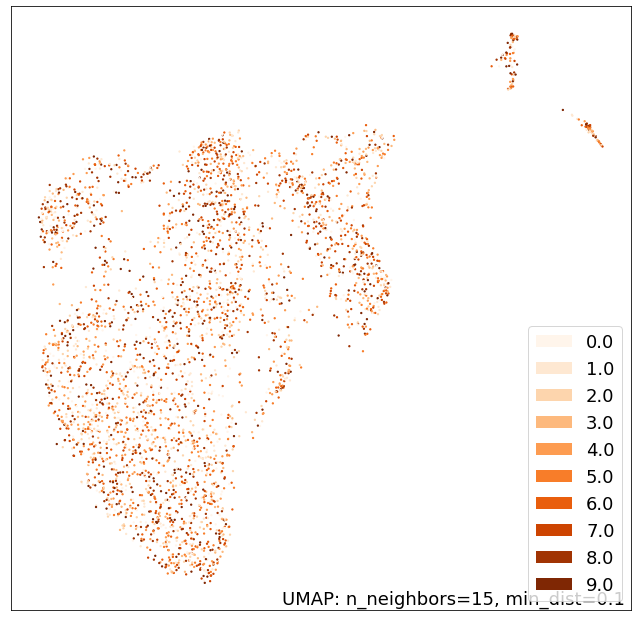

In [14]:
umap.plot.points(mapper, labels=featDf['int_group'], color_key_cmap="Oranges", background='white')
plt.savefig(f'../figures/seqbasedfeatsumap.png', dpi=100)

### Classification (RF)
Does a sequence belong to the upper (decile>=5) or lower FI range?

In [15]:
df_subset = featDf.copy()
df_subset['int_bool'] = df_subset.int_group.astype(float) >= 5
X = df_subset.loc[:,features]
y = df_subset.int_bool
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    stratify=df_subset.int_bool, random_state=123456)

Checking how well a Decision Tree can distinguish the label

Mean accuracy score: 0.611


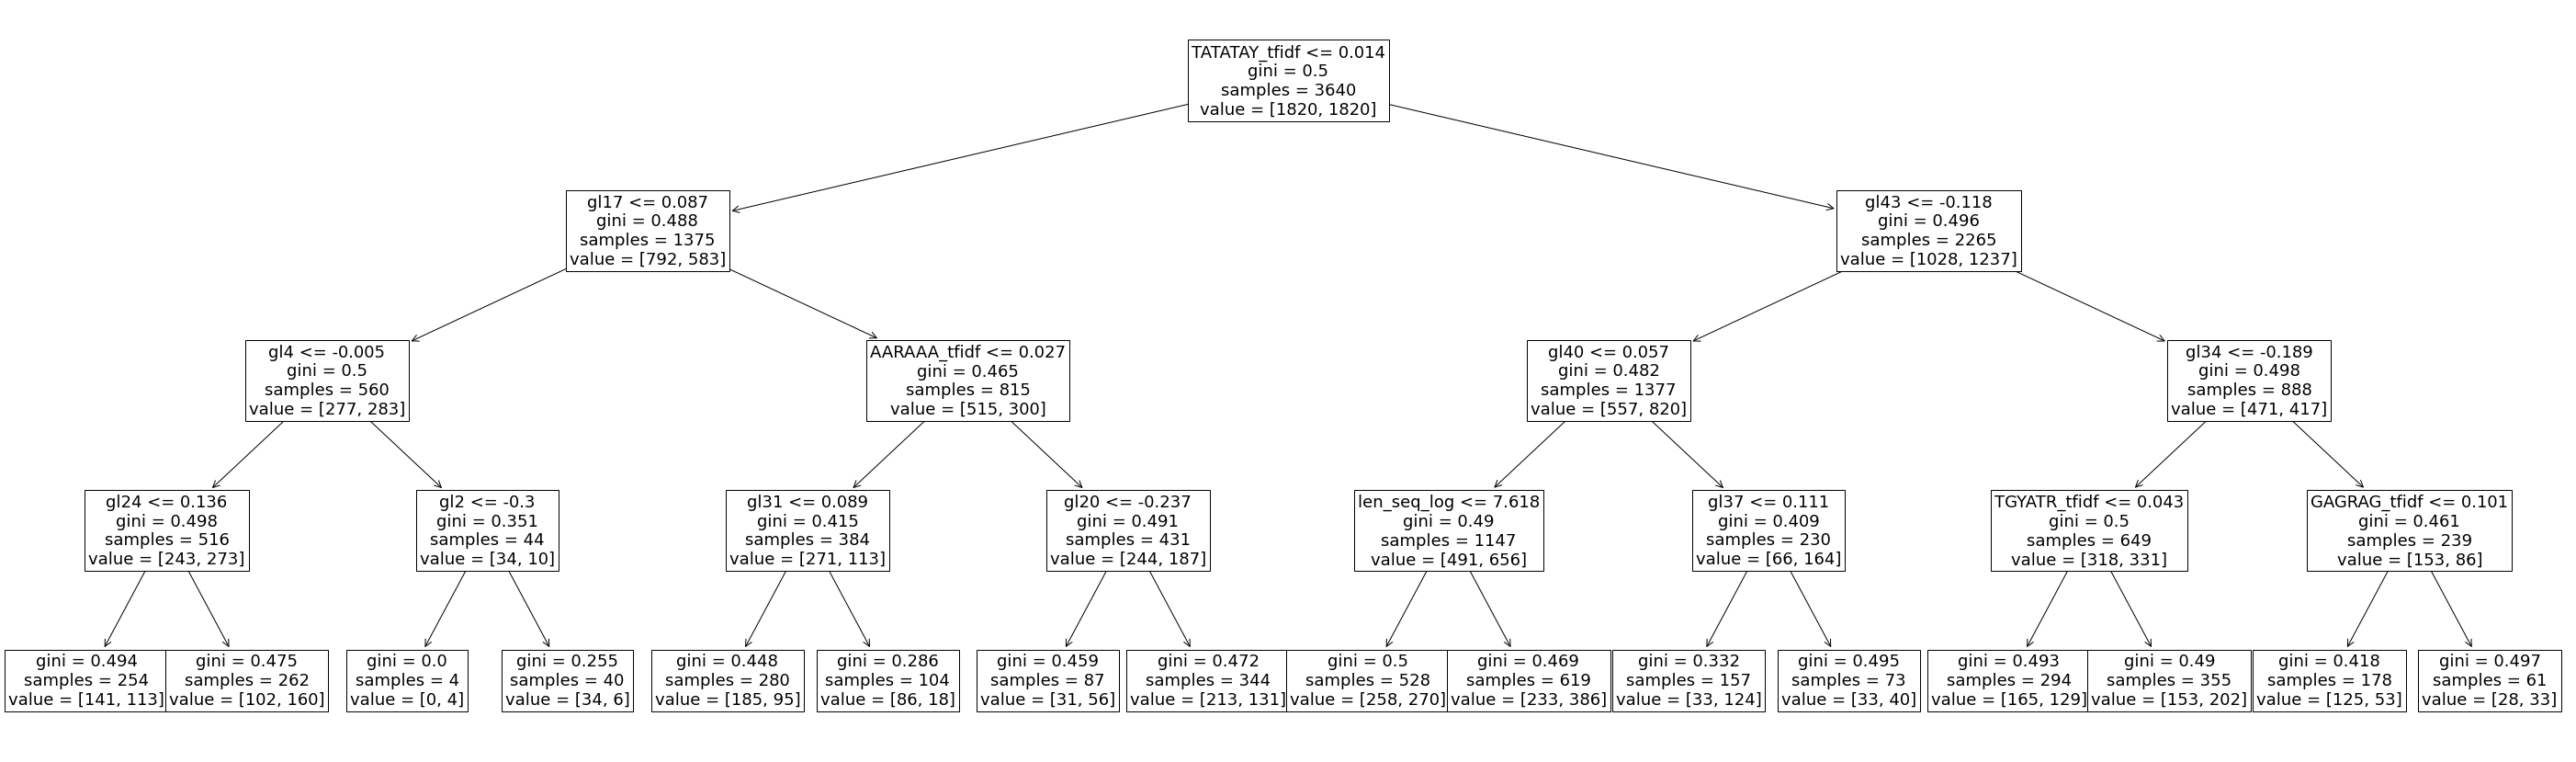

In [16]:
t = DecisionTreeClassifier(random_state=123456, max_depth=4)
t.fit(X, y)
predicted = t.predict(X)
accuracy = accuracy_score(y, predicted)
print(f'Mean accuracy score: {accuracy:.3}')
fig,ax=plt.subplots(1,1, figsize=(50,15))
_ = plot_tree(t,feature_names=features,ax=ax,fontsize=18)

In [18]:
rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

/home/vaslem/code/addalova_bip/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456)

In [19]:
predicted = rf.predict(X_train)
accuracy = accuracy_score(y_train, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.576
Mean accuracy score: 1.0


In [20]:

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.576
Mean accuracy score: 0.582


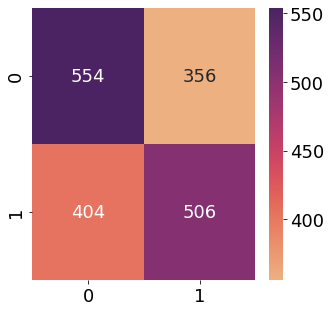

In [21]:
plt.figure(figsize=(5,5))
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=range(2), index=range(2))
sns.heatmap(cm, annot=True, cmap='flare',fmt='d')
plt.savefig('../figures/classification_cm.png')

<Figure size 576x576 with 0 Axes>

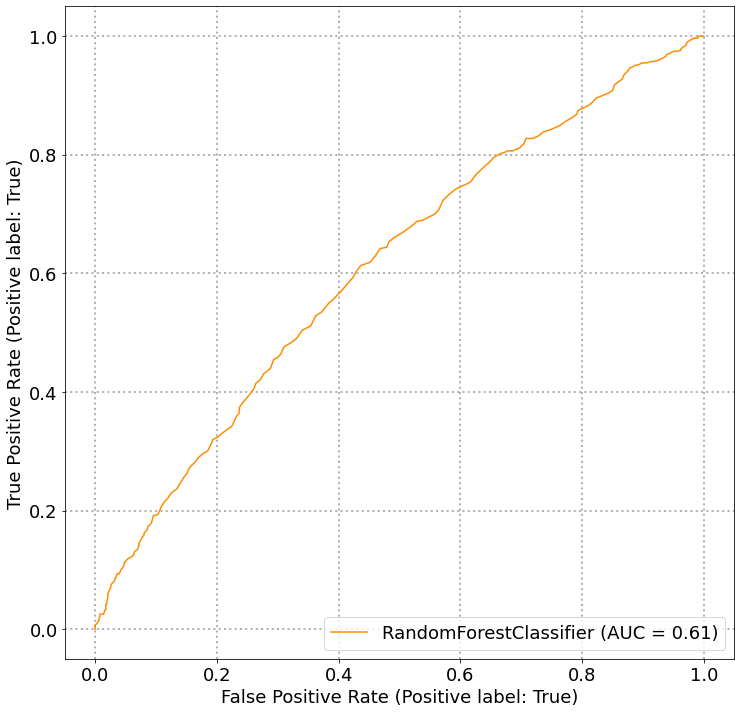

In [22]:
plt.figure(figsize=(8,8))
rf_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test, color='darkorange')
plt.savefig('../figures/classification_roc.png')

### Regression (RF)

In [23]:
df_subset.shape

(3640, 118)

In [1]:
df_subset = featDf.copy()
X = df_subset.loc[:,features]
y = df_subset.intensity

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

NameError: name 'featDf' is not defined

Checking how well a Decision Tree can distinguish intensities

MSE: 2.97


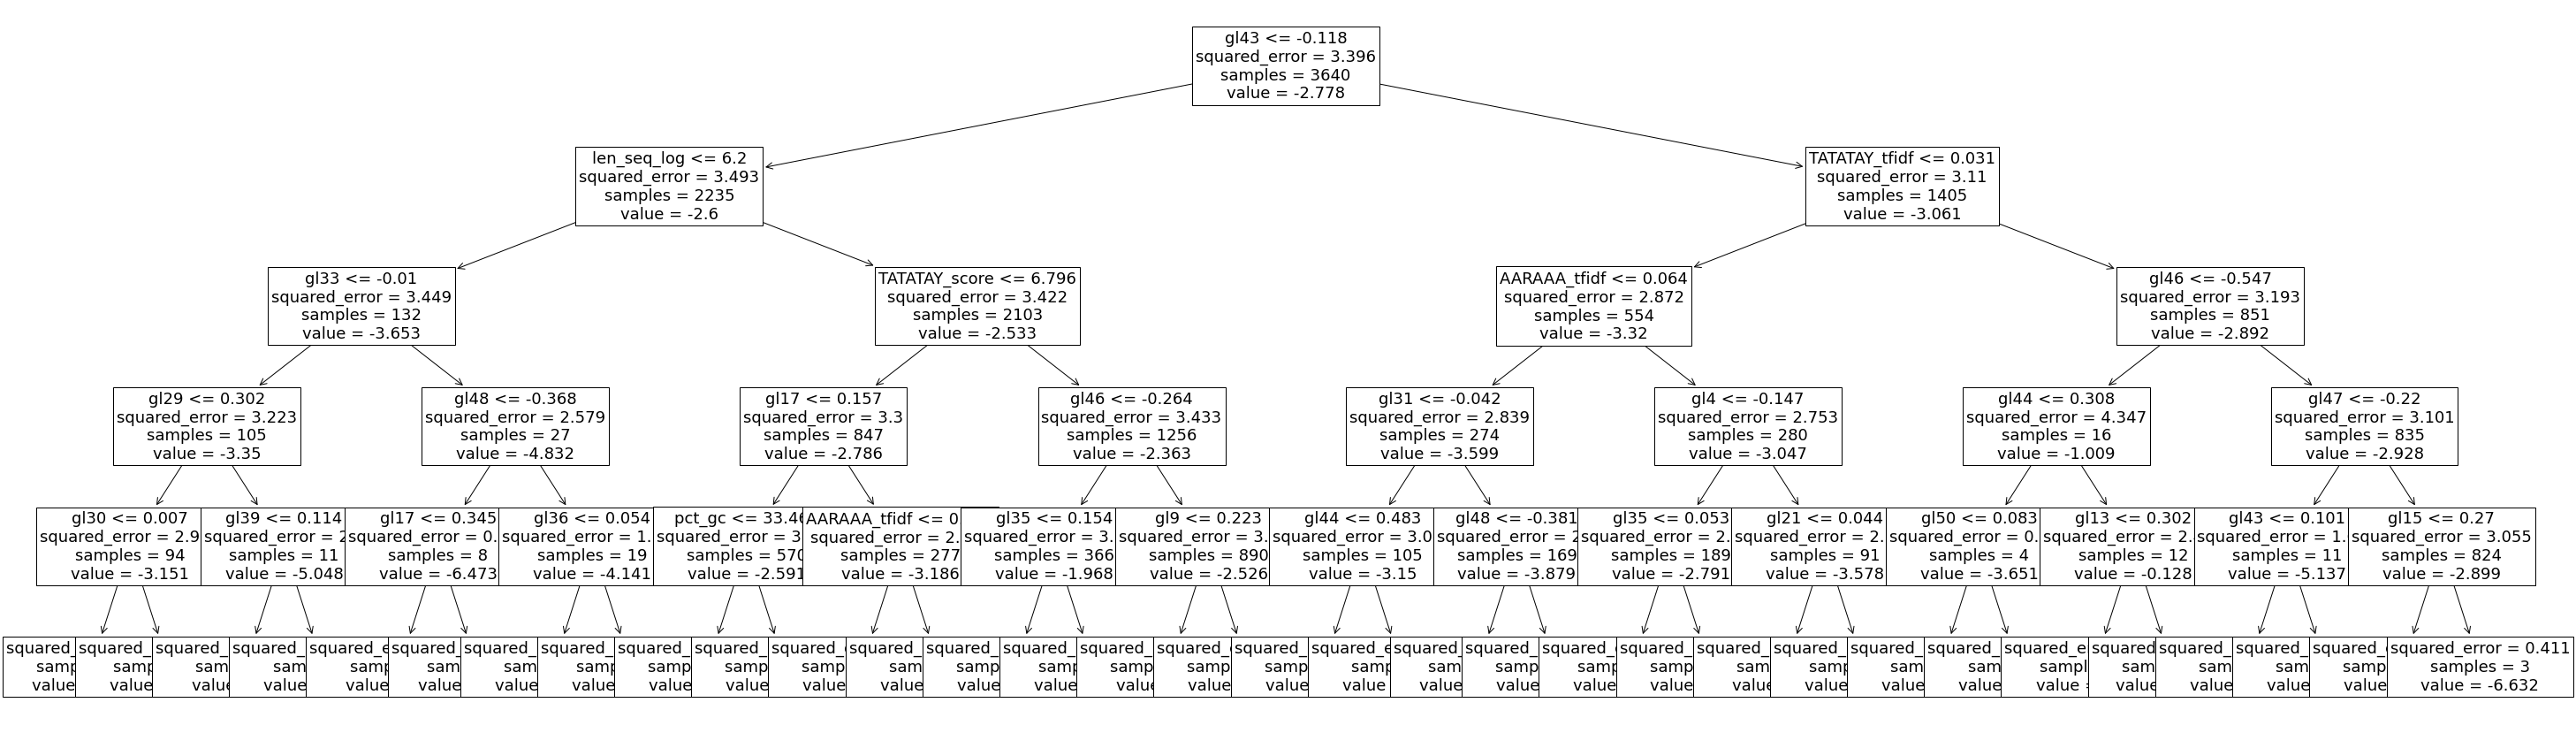

In [25]:
t = DecisionTreeRegressor(random_state=123456, max_depth=5)
t.fit(X, y)
predicted = t.predict(X)
m = mse(y, predicted)
print(f'MSE: {m:.3}')
fig,ax=plt.subplots(1,1, figsize=(50,15))
_ = plot_tree(t,feature_names=features,ax=ax,fontsize=18)

In [26]:
rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)

/home/vaslem/code/addalova_bip/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True,
                      random_state=0)

In [27]:
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
m = mse(y_test, predicted_test)
print(f'Test data MSE: {m:.3}')
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Test data MSE: 3.05
Out-of-bag R-2 score estimate: 0.0564
Test data R-2 score: 0.0545
Test data Spearman correlation: 0.225
Test data Pearson correlation: 0.236


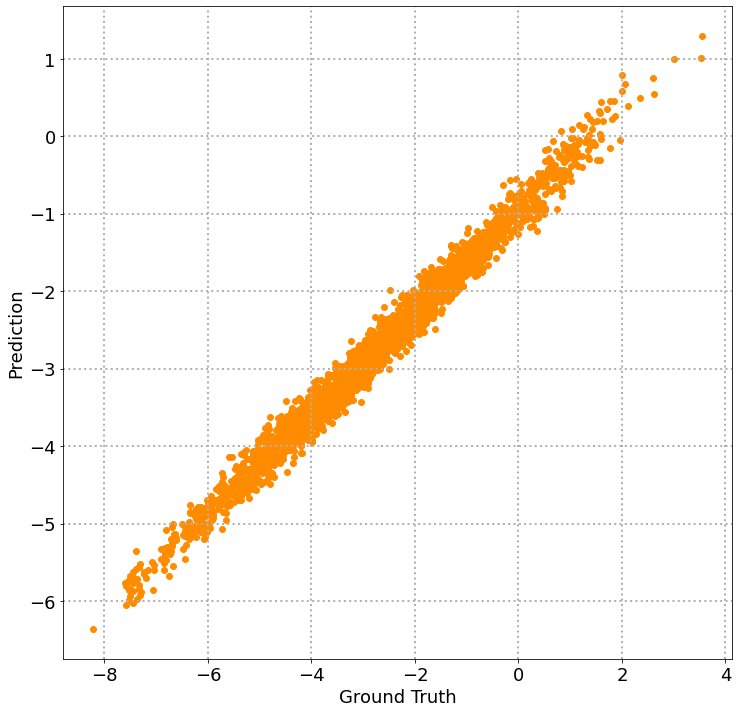

In [28]:
plt.scatter(y_train, predicted_train, color='darkorange')
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.savefig('../figures/reg_training_scatter.png')

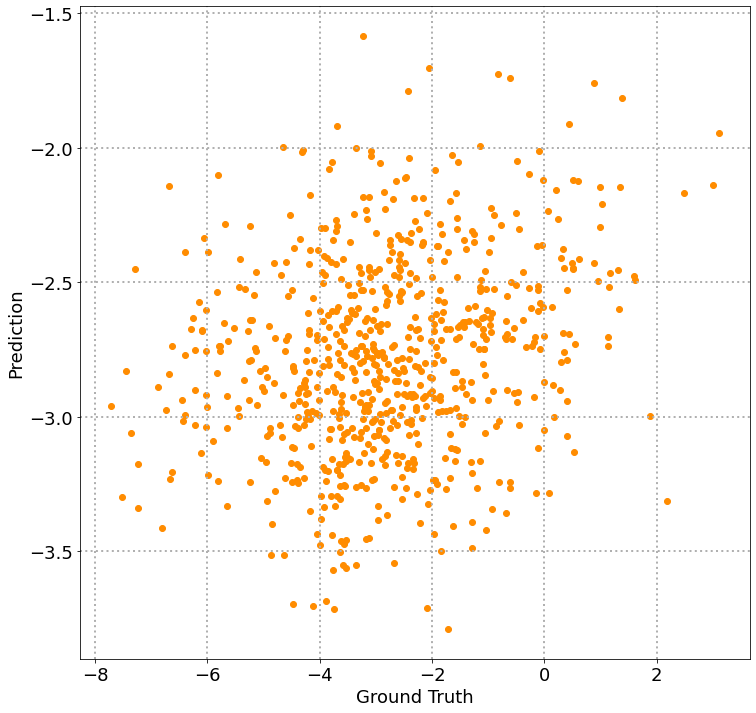

In [29]:
plt.scatter(y_test, predicted_test, color='darkorange')
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.savefig('../figures/reg_testing_scatter.png')

### Try only using groups 0 and 9

In [29]:
df_subset = featDf.loc[featDf['int_group'].isin([0,9]), features + ['int_group']
                       ].copy()
df_subset['int_bool'] = df_subset.int_group.astype(float) >= 5
X = df_subset[features]
y = df_subset.int_bool

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    stratify=df_subset.int_bool, random_state=123456)
rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

predicted = rf.predict(X_train)
accuracy = accuracy_score(y_train, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy train score: {accuracy:.3}')
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy test score: {accuracy:.3}')

/home/vaslem/code/addalova_bip/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Out-of-bag score estimate: 0.635
Mean accuracy train score: 1.0
Mean accuracy test score: 0.624


<Figure size 576x576 with 0 Axes>

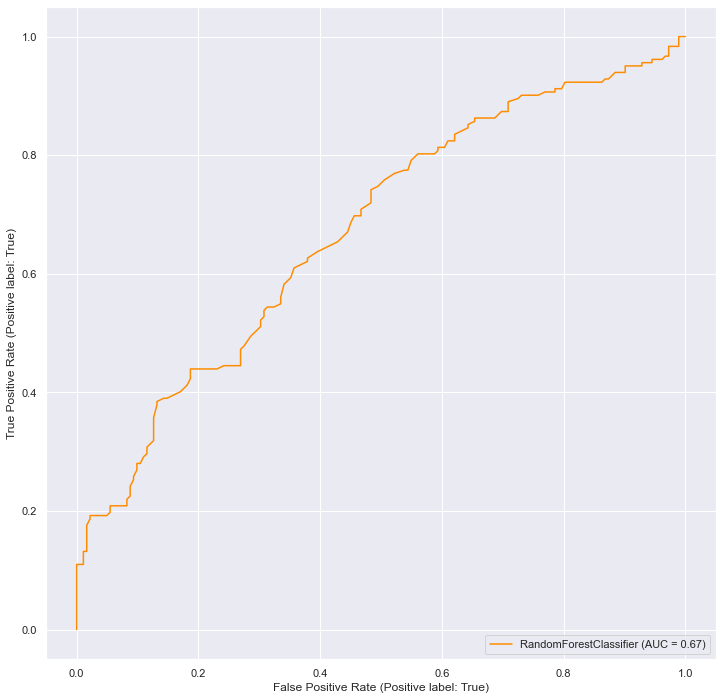

In [30]:
plt.figure(figsize=(8,8))
rf_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test, color='darkorange')
plt.savefig('../figures/09classification_roc.png')

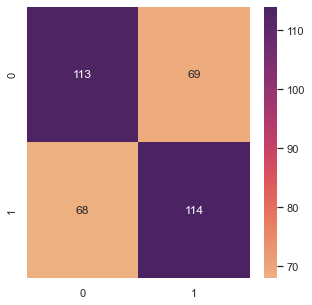

In [31]:
plt.figure(figsize=(5,5))
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=range(2), index=range(2))
sns.heatmap(cm, annot=True, cmap='flare',fmt='d')
plt.savefig('../figures/09classification_cm.png')

Mean accuracy score: 0.698


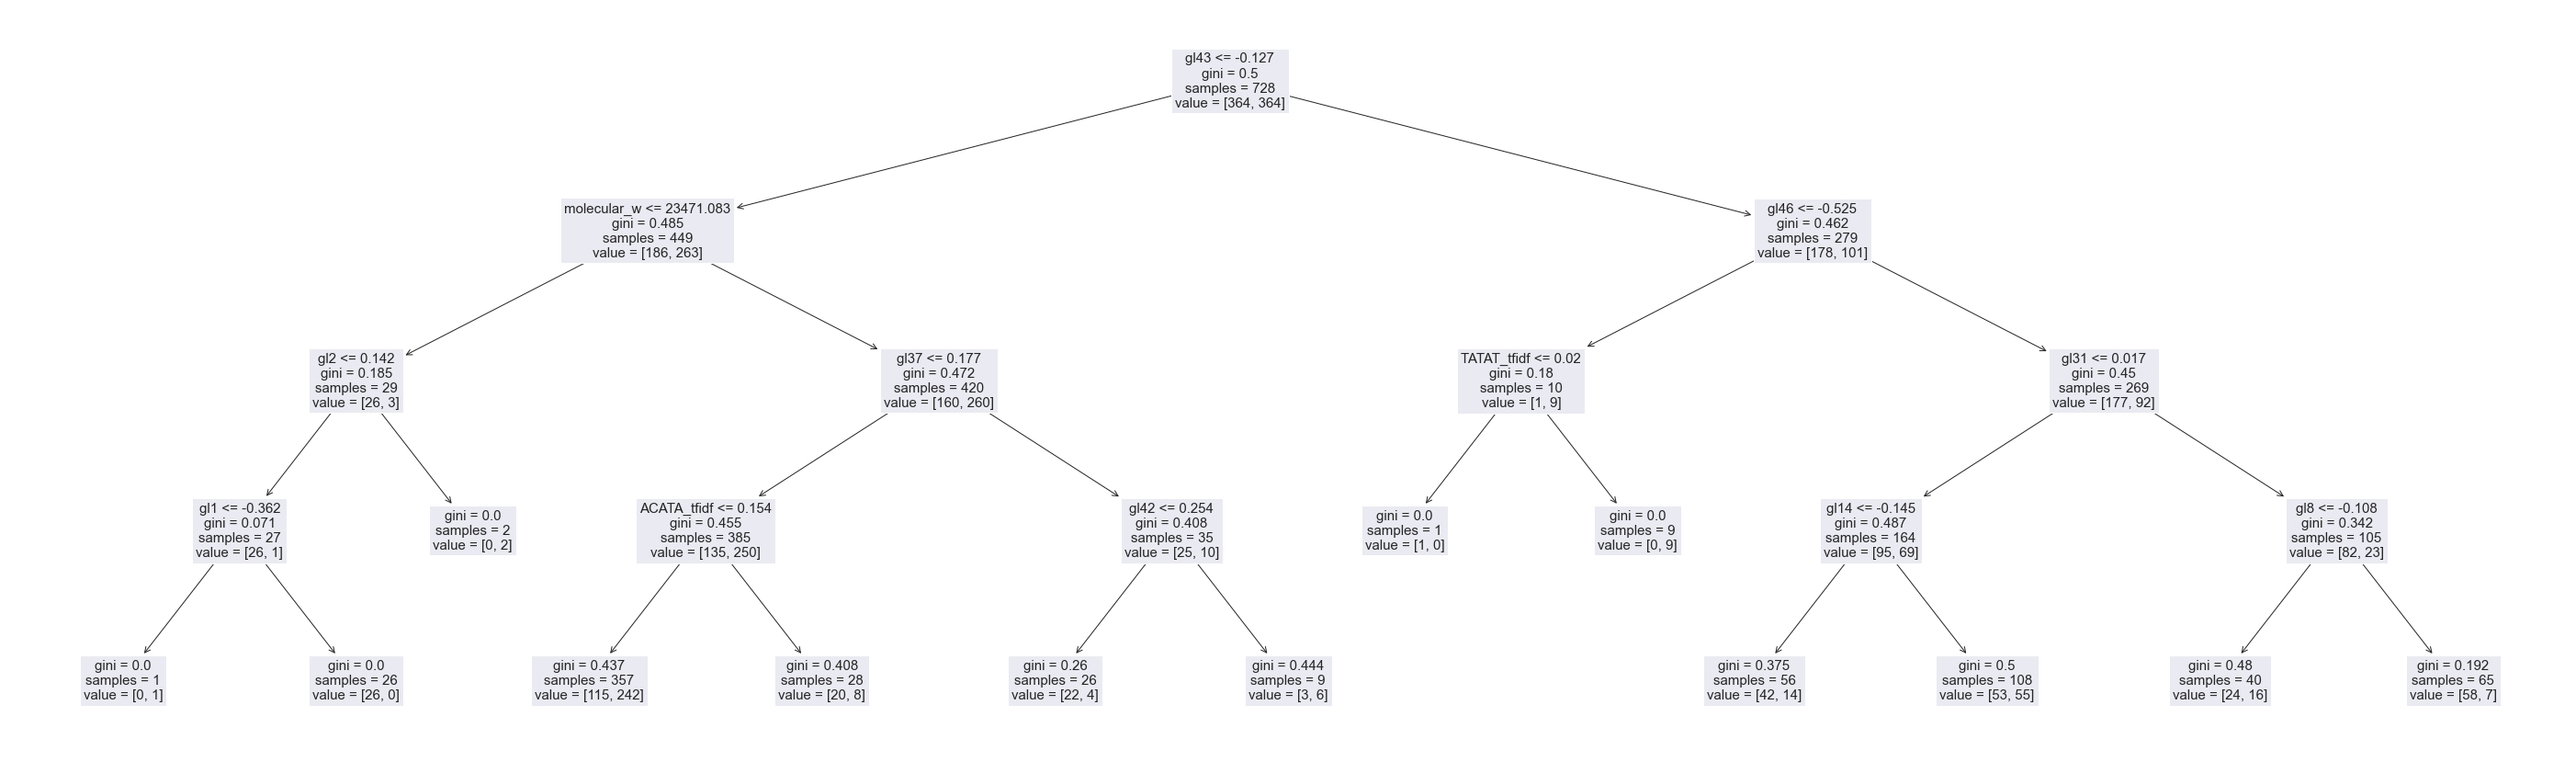

In [32]:
t = DecisionTreeClassifier(random_state=123456, max_depth=4)
t.fit(X, y)
predicted = t.predict(X)
accuracy = accuracy_score(y, predicted)
print(f'Mean accuracy score: {accuracy:.3}')
fig,ax=plt.subplots(1,1, figsize=(50,15))
_ = plot_tree(t,feature_names=features,ax=ax,fontsize=15)
plt.savefig(f'../figures/09classification_tree.png', dpi=100)